In [1]:
import cv2
import torch
import numpy as np
import torchvision
from eprocessing.dataload import ImageDataset
from eprocessing.etransforms import Scale, RandCrop, AddAWGN
from etrain.trainer import NNTrainer
from modelbuild.denoiser import DivergentRestorer
from emetrics.metrics import *

from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn

class PixelFrequencyLayer(nn.Module):
    def __init__(self, num_bins=256):
        """
        Initialize the layer.
        Args:
            num_bins (int): Number of bins for the pixel intensity values (default: 256 for 8-bit images).
        """
        super(PixelFrequencyLayer, self).__init__()
        self.num_bins = num_bins
        self.register_buffer("pixel_probabilities", torch.ones(num_bins) / num_bins)
    
    def compute_frequencies(self, images):
        """
        Compute pixel intensity frequencies and update probabilities.
        Args:
            images (torch.Tensor): Input images (batch_size, channels, height, width).
        """
        with torch.no_grad():
            # Flatten and compute histogram
            flat_pixels = images.flatten()
            hist = torch.histc(flat_pixels, bins=self.num_bins, min=0, max=self.num_bins - 1)
            
            # Normalize histogram to probabilities
            total_pixels = flat_pixels.numel()
            self.pixel_probabilities = hist / total_pixels

    def forward(self, images):
        """
        Transform the input image pixels into probabilities.
        Args:
            images (torch.Tensor): Input images (batch_size, channels, height, width).
        Returns:
            torch.Tensor: Transformed images with probabilities.
        """
        # Map pixel values to probabilities
        pixel_indices = images.long()  # Ensure pixel values are integers
        probabilities = self.pixel_probabilities[pixel_indices]
        return probabilities

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelwiseVariance(nn.Module):
    def __init__(self, kernel_size: int, stride: int = 1, padding: int = 0):
        """
        Custom layer to compute channel-wise variance maps.
        
        Args:
            kernel_size (int): Size of the kernel (assumed square).
            stride (int): Stride for the sliding window.
            padding (int): Padding to apply to the input.
        """
        super(ChannelwiseVariance, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = nn.ReplicationPad2d()

    def forward(self, x):
        """
        Compute channel-wise variance maps.

        Args:
            x (Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            Tensor: Variance map of shape (B, C, H', W').
        """
        B, C, H, W = x.shape

        # Unfold the input to extract patches of shape (B, C, kernel_size*kernel_size, L)
        patches = F.unfold(
            x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding
        )  # Shape: (B, C * kernel_size^2, L)

        # Reshape to (B, C, kernel_size*kernel_size, L)
        patches = patches.view(B, C, self.kernel_size**2, -1)

        # Compute mean along patch dimension
        mean = patches.mean(dim=2, keepdim=True)  # Shape: (B, C, 1, L)

        # Compute variance along patch dimension
        variance = ((patches - mean) ** 2).mean(dim=2)  # Shape: (B, C, L)

        # Reshape back to spatial dimensions
        h_out = (H + 2 * self.padding - self.kernel_size) // self.stride + 1
        w_out = (W + 2 * self.padding - self.kernel_size) // self.stride + 1
        variance_map = variance.view(B, C, h_out, w_out)

        return variance_map

In [4]:
class ChannelVarianceLayer(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(ChannelVarianceLayer, self).__init__()
        # Create a 2x2 kernel for each channel, initialize to 1/4 (for mean calculation)
        self.kernel = torch.ones((in_channels, 1, 2, 2)) / 4.0

    def forward(self, x):
        # Get the size of the input tensor
        batch_size, channels, height, width = x.size()
        
        # Padding to maintain the same size
        padding = (1, 0, 1, 0)
        x_padded = F.pad(x, padding, mode='replicate')
        
        # Compute the squared values for variance calculation
        squared_x = x_padded ** 2
        
        # Apply 2x2 average kernel to compute the mean squared values (i.e., second moment)
        mean_squared = F.conv2d(squared_x, self.kernel, stride=1, padding=0, groups=channels)

        # Apply 2x2 average kernel to compute the mean (i.e., first moment)
        mean = F.conv2d(x_padded, self.kernel, stride=1, padding=0, groups=channels)

        # Compute the variance: variance = E[X^2] - (E[X])^2
        variance_map = mean_squared - mean ** 2

        # Since the variance computation is applied to the padded version, remove the padding
        variance_map = variance_map
        
        return variance_map

In [5]:
xp = Path('D:/Projects/datasets/GoPro/GoPro_Large/orig_blur/awgn-0-0/test/y')
yp = Path('D:/Projects/datasets/GoPro/GoPro_Large/orig_blur/awgn-0-0/test/y')

In [6]:
device = 'cuda'
im_shape = (256,256)
min_std, max_std = 5, 15

In [7]:
psnr = PSNRMetric(device)
ssim = SSIMMetric(device)

In [8]:
DECONV1 = {'kern_size': (),
         'max_iters': 100,
         'lmbda': 0.02,
         'iso': True}
DECONV2 = {'kern_size': (),
         'max_iters': 100,
         'rho': 0.004,
         'iso': True}

model = DivergentRestorer(3, 2, 3,
                          3, 4, 86,
                          86, 8,
                          output_activation=torch.nn.Sigmoid(), admms=[DECONV1, DECONV2])

In [9]:
model_d = torch.load(modelp, weights_only=False)

In [10]:
model.load_state_dict(model_d['model_state_dict'])

<All keys matched successfully>

In [11]:
model = model.to(device)
model = model.eval()

In [12]:
imd = ImageDataset(xp, yp, transforms=[Scale(), RandCrop(im_shape), AddAWGN(std_range=(15, 1), both=False)])

In [13]:
imdt = torch.utils.data.DataLoader(imd, shuffle=True, batch_size=4)

## Run on RGB

In [51]:
green = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/colors/green_image.png') / 255.0
# ref_im = resize(ref_im)
green = green[torch.newaxis, ...]

red = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/colors/red_image.png') / 255.0
# ref_im = resize(ref_im)
red = red[torch.newaxis, ...]

blue = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/colors/blue_image.png') / 255.0
# ref_im = resize(ref_im)
blue = blue[torch.newaxis, ...]

In [53]:
outred = model(red.to(device))
outred = outred.to('cpu')

outgreen = model(green.to(device))
outgreen = outgreen.to('cpu')

outblue = model(blue.to(device))
outblue = outblue.to('cpu')

In [62]:
outred_image = np.transpose(outred[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
outred_image = cv2.cvtColor(outred_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/colors/outred.png', outred_image)

outgreen_image = np.transpose(outgreen[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
outgreen_image = cv2.cvtColor(outgreen_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/colors/outgreen.png', outgreen_image)

outblue_image = np.transpose(outblue[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
outblue_image = cv2.cvtColor(outblue_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/colors/outblue.png', outblue_image)

True

## Load test image and add noise

In [63]:
resize = torchvision.transforms.Resize(256)

In [5]:
ref_im = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/ref.png') / 255.0
# ref_im = resize(ref_im)
ref_im = ref_im[torch.newaxis, ...]

In [65]:
cv2_image = np.transpose(ref_im[0].numpy() * 255, (1, 2, 0))
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/baboon256.png', cv2_image)

True

In [13]:
awgn_gen = AddAWGN(std_range=(15, 16), both=False)
noisy_ref = awgn_gen(ref_im, ref_im)
noisy_ref = noisy_ref[0]

In [14]:
cv2_image = np.transpose(noisy_ref[0].numpy() * 255, (1, 2, 0))
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/house/ref_noisy.png', cv2_image)

True

In [16]:
model_out = model(noisy_ref.to(device))

In [17]:
model_out = model_out.to('cpu')

In [18]:
cv2_image = np.transpose(model_out[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('D:/Projects/torch-admm-deconv/test_imgs/house/model_out.png', cv2_image)

True

In [101]:
def fix_ch_shifts(model_out):
    SHIFT = 2.3/255
    return torch.clamp(model_out + SHIFT, 0, 1)

In [102]:
model_out = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/house/model_out.png') / 255.0
model_out = model_out[torch.newaxis, ...]

In [103]:
model_out = fix_ch_shifts(model_out)

### Load ffndet and bm3d image

In [38]:
ffndet = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/house/ffdnet.png') / 255.0
ffndet = ffndet[torch.newaxis, ...]
bm3d = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/house/image_House256rgb_est_s15.bm3d_png.png') / 255.0
bm3d = bm3d[torch.newaxis, ...]

In [28]:
ref_im.shape

torch.Size([1, 3, 256, 256])

In [104]:
print(psnr(model_out, ref_im))
print(ssim(model_out, ref_im))

tensor(26.1878, device='cuda:0')
tensor(0.8898, device='cuda:0')


In [83]:
print(psnr(ffndet, ref_im))
print(ssim(ffndet, ref_im))

tensor(30.4057, device='cuda:0')
tensor(0.8390, device='cuda:0')


In [84]:
print(psnr(bm3d, ref_im))
print(ssim(bm3d, ref_im))

tensor(34.8309, device='cuda:0')
tensor(0.8872, device='cuda:0')


In [28]:
from PIL import Image

In [33]:
green_image = Image.new("RGB", (256, 256), (0, 255, 0))
green_image.save(r"D:/Projects/torch-admm-deconv/test_imgs/colors/green_image.png")
blue_image = Image.new("RGB", (256, 256), (0, 0, 255))
blue_image.save(r"D:/Projects/torch-admm-deconv/test_imgs/colors/blue_image.png")
red_image = Image.new("RGB", (256, 256), (255, 0, 0))
red_image.save(r"D:/Projects/torch-admm-deconv/test_imgs/colors/red_image.png")

## Lookf for difference from borders to center

In [51]:
ref_im = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/ref.png')
mod_im = torchvision.io.read_image('D:/Projects/torch-admm-deconv/test_imgs/house/model_out.png')

In [63]:
ref_mid_x = ref_im[:, 127:129, :]
mod_mid_x = mod_im[:, 127:129, :]
delta_x = np.average(ref_mid_x, axis=1) - np.average(mod_mid_x, axis=1)

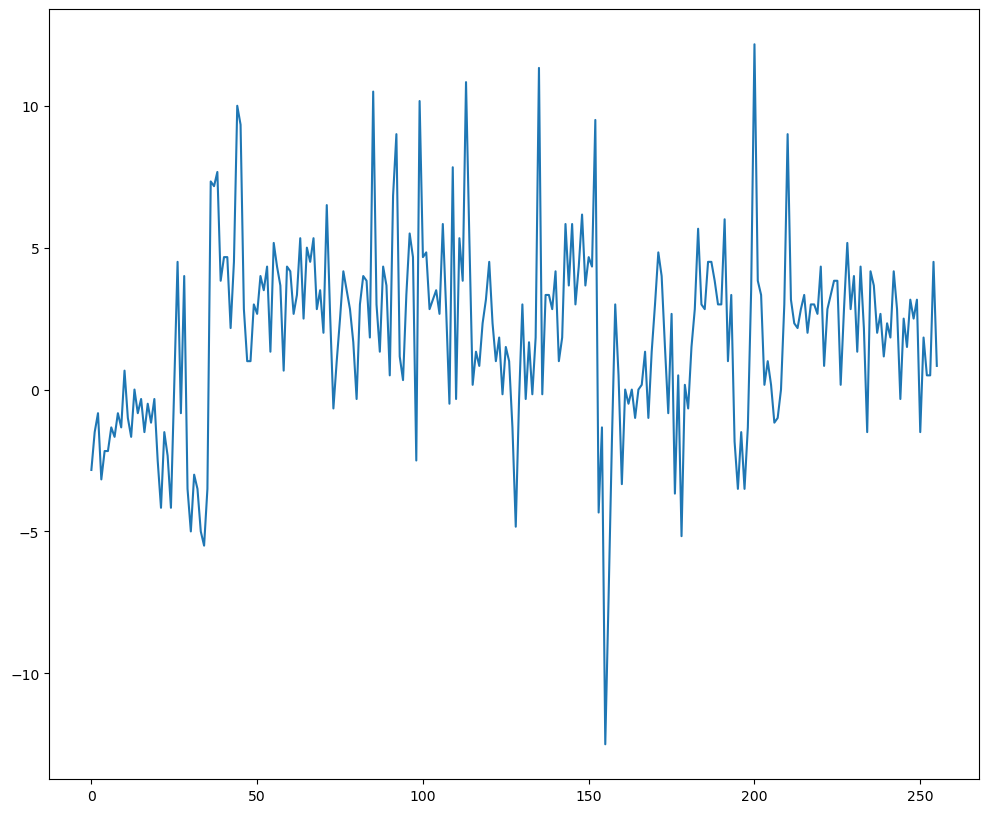

In [64]:
plt.figure(figsize=(12,10))
plt.plot(np.average(delta_x, axis=0))
plt.show()

In [65]:
ref_mid_y = ref_im[:, 2:, 127:129]
mod_mid_y = mod_im[:, 2:, 127:129]
delta_y = np.average(ref_mid_y, axis=2) - np.average(mod_mid_y, axis=2)

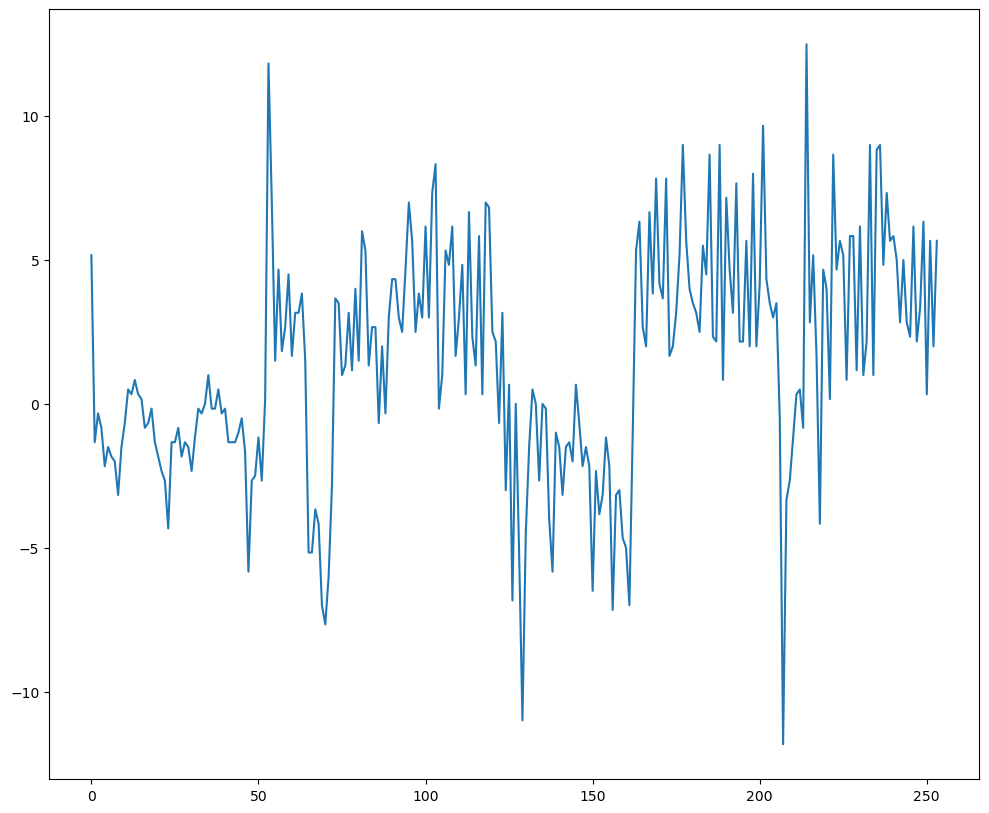

In [66]:
plt.figure(figsize=(12,10))
plt.plot(np.average(delta_y, axis=0))
plt.show()